In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import pickle as pkl
import pandas as pd
import os
import requests as r
from sklearn.metrics import accuracy_score
import random

np.random.seed(37)

random.seed(1254)

tf.random.set_seed(89)


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

script_name = 'Scratch-UTKFace-Age-R50-MultiOutput'



In [2]:
def encode(data, mask):
    labels = []
    for item in data:
        labels.append(mask[item])
    return labels

In [3]:
csv_target_train = 'UTKFace/train.csv'
df_train = pd.read_csv(csv_target_train)
df_train

,gender,race,file,age
0,Male,Asian,UTKFace/images/5_0_2_20161219192745531.jpg.chi...,3-9
1,Female,White,UTKFace/images/60_1_0_20170110122614299.jpg.ch...,50-59
2,Male,Black,UTKFace/images/3_0_1_20170119145547519.jpg.chi...,0-2
3,Male,Black,UTKFace/images/26_0_1_20170117172711486.jpg.ch...,20-29
4,Female,White,UTKFace/images/24_1_0_20170117145637012.jpg.ch...,20-29
...,...,...,...,...
23700,Female,Black,UTKFace/images/46_1_1_20170113012755554.jpg.ch...,40-49
23701,Female,Asian,UTKFace/images/24_1_2_20170116171604159.jpg.ch...,20-29
23702,Male,White,UTKFace/images/40_0_0_20170117185304858.jpg.ch...,30-39
23703,Female,Black,UTKFace/images/31_1_1_20170116224134208.jpg.ch...,30-39


In [4]:
def label2dict(df):
    values = df.unique()
    d = {}
    for idx, v in enumerate(values):
        d[v] = idx
    return d
def apply_encode(map_dict, col, row):
    return map_dict[row[col]]

In [5]:
target_col = ['gender', 'race', 'age']
num_classes = []
for col in target_col:
    num_classes.append(df_train[col].nunique())
input_shape = (112, 112, 3)
batch_size = 64
learning_rate = 0.001
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05
validation_split = 0.2

In [6]:
target_col_data = []
for col in target_col:
    col2 = col + '_sparse'
    target_col_data.append(col2)
    map_dict = label2dict(df_train[col])
    df_train[col2] = df_train.apply(lambda row: apply_encode(map_dict, col, row), axis=1)

In [7]:
x_col = 'file'
y_col = target_col_data
from tensorflow.keras.applications.resnet50 import preprocess_input
train_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=validation_split
)
val_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_iter = train_generator.flow_from_dataframe(
    df_train,
    directory='./',
    x_col=x_col,
    y_col=y_col,
    class_mode="multi_output",
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    subset='training'
)

val_iter = train_generator.flow_from_dataframe(
    df_train,
    directory='./',
    x_col=x_col,
    y_col=y_col,
    class_mode="multi_output",
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    subset='validation'
)

Found 18964 validated image filenames.
Found 4741 validated image filenames.


In [8]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.02),
        layers.experimental.preprocessing.RandomWidth(0.2),
        layers.experimental.preprocessing.RandomHeight(0.2),
    ]
)

In [9]:
callbacks = []
for col in target_col:
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='./ckpt/{}-{}.h5'.format(script_name, col),
        monitor='val_{}_sparse_categorical_accuracy'.format(col),
        mode='max',
        save_best_only=True)
    callbacks.append(model_checkpoint_callback)

In [10]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="utkface-encoder")
    return model


encoder = create_encoder()
encoder.summary()

Model: "utkface-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________


In [11]:
def create_classifier(encoder, trainable=True, training=True):

    encoder.trainable = trainable

    inputs = keras.Input(shape=input_shape, name="input")
    features = encoder(inputs, training=training)
    outputs = []
    for idx, num_class in enumerate(num_classes):
        _features = layers.Dropout(dropout_rate, name="dropout_" + target_col[idx])(features)
        _features = layers.Dense(hidden_units, activation="relu", name = "features"+ target_col[idx])(_features)
        _features = layers.Dropout(dropout_rate, name="dropout2_" + target_col[idx])(_features)
        outputs.append(layers.Dense(num_class, activation="softmax", name=target_col[idx])(_features))

    model = keras.Model(inputs=inputs, outputs=outputs, name="utkface-classifier")
    metrics = {}
    loss = []
    for col in target_col:
        metrics[col] = keras.metrics.SparseCategoricalAccuracy()
        loss.append(keras.losses.SparseCategoricalCrossentropy())
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=loss,
        metrics=metrics
    )
    return model

In [12]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

Model: "utkface-classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
utkface-encoder (Functional)    (None, 2048)         23564800    input[0][0]                      
__________________________________________________________________________________________________
dropout_gender (Dropout)        (None, 2048)         0           utkface-encoder[0][0]            
__________________________________________________________________________________________________
dropout_race (Dropout)          (None, 2048)         0           utkface-encoder[0][0]            
_________________________________________________________________________________

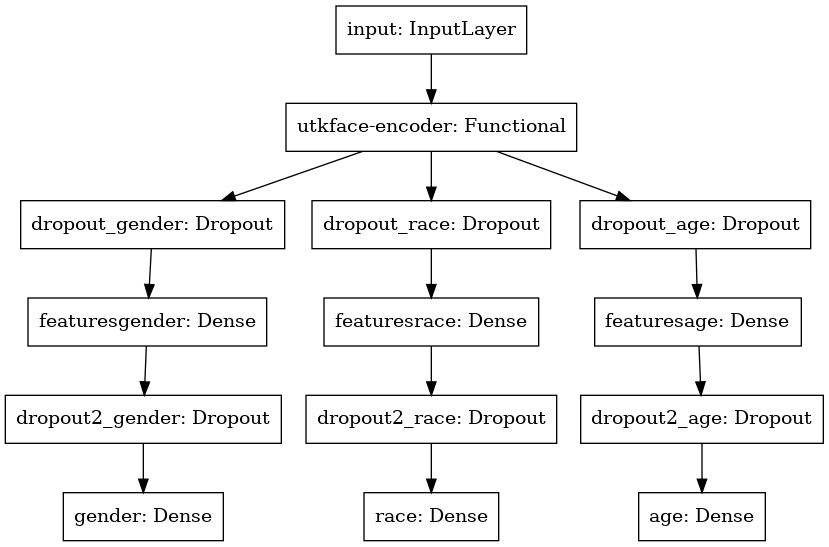

In [13]:
keras.utils.plot_model(classifier)

In [14]:
history = classifier.fit(train_iter, batch_size=batch_size, epochs=num_epochs, validation_data=val_iter, callbacks=callbacks)


Epoch 1/50
297/297 [==============================] - 60s 177ms/step - loss: 3.9384 - gender_loss: 0.6578 - race_loss: 1.3808 - age_loss: 1.8998 - gender_sparse_categorical_accuracy: 0.6479 - race_sparse_categorical_accuracy: 0.4791 - age_sparse_categorical_accuracy: 0.3452 - val_loss: 3.2916 - val_gender_loss: 0.4981 - val_race_loss: 1.1679 - val_age_loss: 1.6257 - val_gender_sparse_categorical_accuracy: 0.7454 - val_race_sparse_categorical_accuracy: 0.5427 - val_age_sparse_categorical_accuracy: 0.4022


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
297/297 [==============================] - 32s 108ms/step - loss: 3.2735 - gender_loss: 0.4794 - race_loss: 1.1762 - age_loss: 1.6180 - gender_sparse_categorical_accuracy: 0.7704 - race_sparse_categorical_accuracy: 0.5510 - age_sparse_categorical_accuracy: 0.4046 - val_loss: 3.0594 - val_gender_loss: 0.4530 - val_race_loss: 1.1015 - val_age_loss: 1.5048 - val_gender_sparse_categorical_accuracy: 0.7830 - val_race_sparse_categorical_accuracy: 0.5792 - val_age_sparse_categorical_accuracy: 0.4278
Epoch 3/50
297/297 [==============================] - 29s 99ms/step - loss: 2.9439 - gender_loss: 0.4029 - race_loss: 1.0464 - age_loss: 1.4946 - gender_sparse_categorical_accuracy: 0.8141 - race_sparse_categorical_accuracy: 0.6096 - age_sparse_categorical_accuracy: 0.4356 - val_loss: 2.7595 - val_gender_loss: 0.3730 - val_race_loss: 0.9601 - val_age_loss: 1.4265 - val_gender_sparse_categorical_accuracy: 0.8285 - val_race_sparse_categorical_accuracy: 0.6355 - val_age_sparse_categorical_

297/297 [==============================] - 26s 88ms/step - loss: 1.8862 - gender_loss: 0.2152 - race_loss: 0.5889 - age_loss: 1.0821 - gender_sparse_categorical_accuracy: 0.9091 - race_sparse_categorical_accuracy: 0.8014 - age_sparse_categorical_accuracy: 0.5567 - val_loss: 1.9282 - val_gender_loss: 0.2362 - val_race_loss: 0.6118 - val_age_loss: 1.0802 - val_gender_sparse_categorical_accuracy: 0.8983 - val_race_sparse_categorical_accuracy: 0.7908 - val_age_sparse_categorical_accuracy: 0.5678
Epoch 19/50
297/297 [==============================] - 26s 88ms/step - loss: 1.8683 - gender_loss: 0.2145 - race_loss: 0.5807 - age_loss: 1.0731 - gender_sparse_categorical_accuracy: 0.9091 - race_sparse_categorical_accuracy: 0.8029 - age_sparse_categorical_accuracy: 0.5627 - val_loss: 1.9206 - val_gender_loss: 0.2556 - val_race_loss: 0.5903 - val_age_loss: 1.0747 - val_gender_sparse_categorical_accuracy: 0.8897 - val_race_sparse_categorical_accuracy: 0.7986 - val_age_sparse_categorical_accuracy: 0

297/297 [==============================] - 26s 86ms/step - loss: 1.5728 - gender_loss: 0.1724 - race_loss: 0.4561 - age_loss: 0.9443 - gender_sparse_categorical_accuracy: 0.9304 - race_sparse_categorical_accuracy: 0.8477 - age_sparse_categorical_accuracy: 0.6049 - val_loss: 1.7547 - val_gender_loss: 0.2217 - val_race_loss: 0.5455 - val_age_loss: 0.9875 - val_gender_sparse_categorical_accuracy: 0.9184 - val_race_sparse_categorical_accuracy: 0.8159 - val_age_sparse_categorical_accuracy: 0.5984
Epoch 35/50
297/297 [==============================] - 26s 89ms/step - loss: 1.5453 - gender_loss: 0.1676 - race_loss: 0.4458 - age_loss: 0.9319 - gender_sparse_categorical_accuracy: 0.9318 - race_sparse_categorical_accuracy: 0.8474 - age_sparse_categorical_accuracy: 0.6188 - val_loss: 1.7651 - val_gender_loss: 0.2124 - val_race_loss: 0.5480 - val_age_loss: 1.0047 - val_gender_sparse_categorical_accuracy: 0.9110 - val_race_sparse_categorical_accuracy: 0.8131 - val_age_sparse_categorical_accuracy: 0

297/297 [==============================] - 26s 86ms/step - loss: 1.3094 - gender_loss: 0.1308 - race_loss: 0.3521 - age_loss: 0.8265 - gender_sparse_categorical_accuracy: 0.9465 - race_sparse_categorical_accuracy: 0.8805 - age_sparse_categorical_accuracy: 0.6538 - val_loss: 1.7590 - val_gender_loss: 0.2152 - val_race_loss: 0.5383 - val_age_loss: 1.0055 - val_gender_sparse_categorical_accuracy: 0.9182 - val_race_sparse_categorical_accuracy: 0.8260 - val_age_sparse_categorical_accuracy: 0.6035


<Response [200]>

In [15]:
classifier.save('./ckpt/{}-{}.h5'.format(script_name, 'last'))

In [16]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = []
    for col in target_col:
        outputs.append(layers.Dense(projection_units, activation="relu", name="features_" + col)(features))
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="utkface-encoder_with_projection-head"
    )
    return model

In [17]:
script_name = 'SupCon-UTKFace-Age-R50-MultiOutput'

Model: "utkface-encoder_with_projection-head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
utkface-encoder (Functional)    (None, 2048)         23564800    input_7[0][0]                    
__________________________________________________________________________________________________
features_gender (Dense)         (None, 128)          262272      utkface-encoder[0][0]            
__________________________________________________________________________________________________
features_race (Dense)           (None, 128)          262272      utkface-encoder[0][0]            
_______________________________________________________________

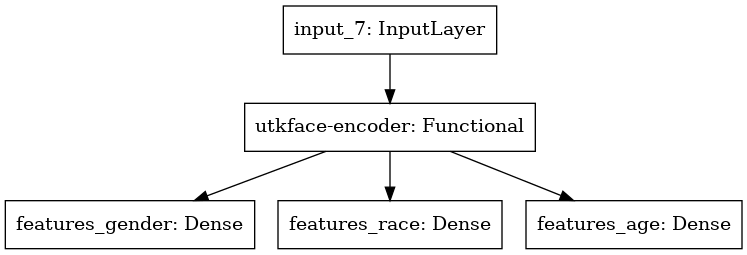

In [18]:
encoder = create_encoder()
loss = []
for col in target_col:
    loss.append(SupervisedContrastiveLoss(temperature))
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=loss,
)

encoder_with_projection_head.summary()
keras.utils.plot_model(encoder_with_projection_head)

In [19]:
history = encoder_with_projection_head.fit(
    train_iter, batch_size=batch_size, epochs=num_epochs
)


Epoch 1/50
297/297 [==============================] - 26s 71ms/step - loss: 12.2281 - features_gender_loss: 4.1313 - features_race_loss: 4.1071 - features_age_loss: 3.9898
Epoch 2/50
297/297 [==============================] - 21s 71ms/step - loss: 11.8928 - features_gender_loss: 4.0442 - features_race_loss: 4.0185 - features_age_loss: 3.8300
Epoch 3/50
297/297 [==============================] - 21s 72ms/step - loss: 11.7002 - features_gender_loss: 3.9956 - features_race_loss: 3.9489 - features_age_loss: 3.7556
Epoch 4/50
297/297 [==============================] - 21s 70ms/step - loss: 11.5363 - features_gender_loss: 3.9609 - features_race_loss: 3.8617 - features_age_loss: 3.7137
Epoch 5/50
297/297 [==============================] - 21s 71ms/step - loss: 11.3968 - features_gender_loss: 3.9294 - features_race_loss: 3.7912 - features_age_loss: 3.6762
Epoch 6/50
297/297 [==============================] - 21s 71ms/step - loss: 11.2804 - features_gender_loss: 3.9090 - features_race_loss: 3.7

297/297 [==============================] - 21s 71ms/step - loss: 10.1598 - features_gender_loss: 3.6652 - features_race_loss: 3.2467 - features_age_loss: 3.2479
Epoch 49/50
297/297 [==============================] - 21s 71ms/step - loss: 10.1541 - features_gender_loss: 3.6667 - features_race_loss: 3.2437 - features_age_loss: 3.2437
Epoch 50/50
297/297 [==============================] - 21s 71ms/step - loss: 10.1487 - features_gender_loss: 3.6682 - features_race_loss: 3.2382 - features_age_loss: 3.2423


<Response [200]>

In [20]:
callbacks = []
for col in target_col:
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='./ckpt/{}-{}.h5'.format(script_name, col),
        monitor='val_{}_sparse_categorical_accuracy'.format(col),
        mode='max',
        save_best_only=True)
    callbacks.append(model_checkpoint_callback)

In [21]:
classifier = create_classifier(encoder, trainable=False, training=False)
classifier.summary()
history = classifier.fit(train_iter, batch_size=batch_size, epochs=10, validation_data=val_iter, callbacks=callbacks)

Model: "utkface-classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
utkface-encoder (Functional)    (None, 2048)         23564800    input[0][0]                      
__________________________________________________________________________________________________
dropout_gender (Dropout)        (None, 2048)         0           utkface-encoder[1][0]            
__________________________________________________________________________________________________
dropout_race (Dropout)          (None, 2048)         0           utkface-encoder[1][0]            
_________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
297/297 [==============================] - 25s 84ms/step - loss: 1.2920 - gender_loss: 0.1096 - race_loss: 0.3328 - age_loss: 0.8496 - gender_sparse_categorical_accuracy: 0.9653 - race_sparse_categorical_accuracy: 0.8989 - age_sparse_categorical_accuracy: 0.6521 - val_loss: 1.6846 - val_gender_loss: 0.2165 - val_race_loss: 0.4991 - val_age_loss: 0.9690 - val_gender_sparse_categorical_accuracy: 0.9312 - val_race_sparse_categorical_accuracy: 0.8454 - val_age_sparse_categorical_accuracy: 0.6121
Epoch 3/10
297/297 [==============================] - 25s 84ms/step - loss: 1.2543 - gender_loss: 0.1029 - race_loss: 0.3188 - age_loss: 0.8325 - gender_sparse_categorical_accuracy: 0.9685 - race_sparse_categorical_accuracy: 0.9019 - age_sparse_categorical_accuracy: 0.6532 - val_loss: 1.6675 - val_gender_loss: 0.1850 - val_race_loss: 0.5043 - val_age_loss: 0.9781 - val_gender_sparse_categorical_accuracy: 0.9325 - val_race_sparse_categorical_accuracy: 0.8492 - val_age_sparse_categorical_a

<Response [200]>

In [22]:
classifier.trainable = True
classifier.summary()
history = classifier.fit(train_iter, batch_size=batch_size, epochs=40, initial_epoch=10, validation_data=val_iter, callbacks=callbacks)

Model: "utkface-classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
utkface-encoder (Functional)    (None, 2048)         23564800    input[0][0]                      
__________________________________________________________________________________________________
dropout_gender (Dropout)        (None, 2048)         0           utkface-encoder[1][0]            
__________________________________________________________________________________________________
dropout_race (Dropout)          (None, 2048)         0           utkface-encoder[1][0]            
_________________________________________________________________________________

Epoch 21/40
297/297 [==============================] - 25s 83ms/step - loss: 1.1846 - gender_loss: 0.0908 - race_loss: 0.2913 - age_loss: 0.8025 - gender_sparse_categorical_accuracy: 0.9713 - race_sparse_categorical_accuracy: 0.9095 - age_sparse_categorical_accuracy: 0.6642 - val_loss: 1.7600 - val_gender_loss: 0.2231 - val_race_loss: 0.5348 - val_age_loss: 1.0022 - val_gender_sparse_categorical_accuracy: 0.9333 - val_race_sparse_categorical_accuracy: 0.8511 - val_age_sparse_categorical_accuracy: 0.5967
Epoch 22/40
297/297 [==============================] - 25s 83ms/step - loss: 1.1802 - gender_loss: 0.0893 - race_loss: 0.2898 - age_loss: 0.8011 - gender_sparse_categorical_accuracy: 0.9707 - race_sparse_categorical_accuracy: 0.9083 - age_sparse_categorical_accuracy: 0.6665 - val_loss: 1.7295 - val_gender_loss: 0.2128 - val_race_loss: 0.5174 - val_age_loss: 0.9993 - val_gender_sparse_categorical_accuracy: 0.9312 - val_race_sparse_categorical_accuracy: 0.8528 - val_age_sparse_categorical

297/297 [==============================] - 25s 84ms/step - loss: 1.1624 - gender_loss: 0.0887 - race_loss: 0.2816 - age_loss: 0.7921 - gender_sparse_categorical_accuracy: 0.9709 - race_sparse_categorical_accuracy: 0.9113 - age_sparse_categorical_accuracy: 0.6666 - val_loss: 1.7949 - val_gender_loss: 0.2210 - val_race_loss: 0.5535 - val_age_loss: 1.0204 - val_gender_sparse_categorical_accuracy: 0.9308 - val_race_sparse_categorical_accuracy: 0.8536 - val_age_sparse_categorical_accuracy: 0.5982
Epoch 38/40
297/297 [==============================] - 25s 84ms/step - loss: 1.1634 - gender_loss: 0.0886 - race_loss: 0.2830 - age_loss: 0.7918 - gender_sparse_categorical_accuracy: 0.9707 - race_sparse_categorical_accuracy: 0.9113 - age_sparse_categorical_accuracy: 0.6673 - val_loss: 1.7896 - val_gender_loss: 0.2444 - val_race_loss: 0.5382 - val_age_loss: 1.0069 - val_gender_sparse_categorical_accuracy: 0.9314 - val_race_sparse_categorical_accuracy: 0.8513 - val_age_sparse_categorical_accuracy: 0

<Response [200]>

In [23]:
classifier.save('./ckpt/{}-{}.h5'.format(script_name, 'last'))

In [24]:
res = []
names = ['Scratch-UTKFace-Age-R50-MultiOutput-{}.h5', 'SupCon-UTKFace-Age-R50-MultiOutput-{}.h5']
for name in names:
    for col in target_col + ['last']:
        model_file = 'ckpt/' + name.format(col)
        model = keras.models.load_model(model_file)
        eval_res = model.evaluate(val_iter)
        eval_res = [name.format(col)] + eval_res
        res.append(eval_res)          
df_res = pd.DataFrame(res, columns = ['name', 'total_loss', 'gender_loss', 'race_loss', 'age_loss', 'gender_acc', 'race_acc', 'age_acc'])
df_res.to_csv('Compare - Scratch - SupCon - UTKFace.csv')

75/75 [==============================] - 6s 67ms/step - loss: 1.7821 - gender_loss: 0.2312 - race_loss: 0.5484 - age_loss: 1.0025 - gender_sparse_categorical_accuracy: 0.9327 - race_sparse_categorical_accuracy: 0.8515 - age_sparse_categorical_accuracy: 0.6100
